# Mini-projet groupe 3 : optimisation -- Léa Mailhol / Léo Simplet

In [1]:
from math import *
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd
import copy
import scipy.optimize

## I. Modélisation

Pour cette partie, veuillez vous réferer au document $\LaTeX$ fournit dans le premier mail.
On considère toutefois dans la suite du projet la fonction et les notations utilisées dans la correction de la partie Modélisation.

Il nous semble tout de même étrange de considérer l'angle $\theta_i$ dans la somme correspondant aux fermetures de boucle, car nous pensons que ce n'est pas le bon angle entre les points $x_j$ et $x_i$. Peut-être faudrait il utiliser un autre angle. Dans le doute, nous avons adopté la fonction définie dans la correction.

## II. Étude et résolution numérique 

#### Question 1 : 

In [2]:
with open(r"INTEL.txt", "r") as contenu:
    #Ouverture du fichier
    
    L = [] #L est la liste des relations de fermeture de boucle 
    c = 0 #c compte le nombre de points 

    for ligne in contenu :
        if "EDGE_ODO" in ligne:
            c += 1

with open(r"INTEL.txt", "r") as contenu:

    #Creation de la matrice des Delta(ij)
    deltaP = [[0 for i in range(c+1)] for j in range(c+1)]

    for ligne in contenu :
        contenu_ligne = ligne.split()
        if "EDGE_ODO" in ligne:
            #Stockage des dx, dy, dtheta
            i = int(contenu_ligne[1])
            deltaP[i][i+1] = [float(contenu_ligne[3]), float(contenu_ligne[4]), float(contenu_ligne[5])]
        elif "EDGE_LOOP" in ligne :
            i = int(contenu_ligne[1])
            j = int(contenu_ligne[2])
            L.append((i,j))
            deltaP[i][j] = [float(contenu_ligne[3]), float(contenu_ligne[4]), float(contenu_ligne[5])]


    P = [[0.,0.,0.]]           #Liste des [x, y, theta] pour chaque position
    for i in range(c) :
        #Calculs des positions par iteration grace aux formules de recurrence
        delta = deltaP[i][i+1]
        P += [[(np.cos(P[-1][2])*delta[0] - np.sin(P[-1][2])*delta[1] + P[-1][0]),
        (np.sin(P[-1][2])*delta[0] + np.cos(P[-1][2])*delta[1] + P[-1][1]),
        (P[-1][2] + delta[2])]]

#### Question 2 :

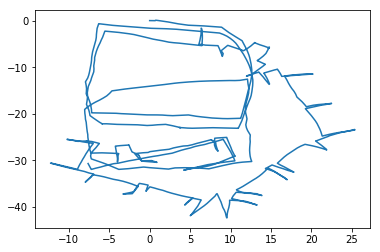

In [3]:
X, Y = [], []
for [x,y,theta] in P:
    X.append(x)
    Y.append(y)
X = np.array(X)
Y = np.array(Y)
plt.plot(X,Y)
plt.show()

On remarque que le robot emprunte plusieurs fois le même chemin mais cela apparaît comme deux chemins différents sur la trajectoire. Grâce aux relations de fermetures de boucle, on pourra être sûr que le robot a bien emprunté le même chemin et donc simplifier la trajectoire et la rendre plus précise.

#### Question 3 : 

In [4]:
gamma = 1

def fonction_f(p) :
    """
    Cette fonction est implementee pour travailler sur le vecteur p=((x0,y0,theta0), (x1,y1,theta1), ..., (xn, yn, thetan))
    """
    S1 = 0
    S2 = 0
    N = len(p)
    for i in range (N-1) :
        S1 += (p[i+1][0] - np.cos(p[i][2])*deltaP[i][i+1][0] + np.sin(p[i][2])*deltaP[i][i+1][1] - p[i][0])**2
        S1 += (p[i+1][1] - np.sin(p[i][2])*deltaP[i][i+1][0] - np.cos(p[i][2])*deltaP[i][i+1][1] - p[i][1])**2
        S1 += (p[i+1][2] - deltaP[i][i+1][2] - p[i][2])**2

    for (i,j) in L :
        S2 += (p[j][0] - np.cos(p[i][2])*deltaP[i][j][0] + np.sin(p[i][2])*deltaP[i][j][1] - p[i][0])**2
        S2 += (p[j][1] - np.sin(p[i][2])*deltaP[i][j][0] - np.cos(p[i][2])*deltaP[i][j][1] - p[i][1])**2
        S2 += (p[j][2] - deltaP[i][j][2] - p[i][2])**2
    return S1 + gamma * S2

print(fonction_f(P))

612744.015894


##### Convexité :

Nous cherchons à montrer que notre fonction f n'est pas convexe. Posons 3N le nombre de variables d'entrée de cette fonction (ces variables sont les $x_1, y_1, \theta_1, \dots, x_N, y_N, \theta_N$). Nous allons fixer 2N de ces variables (en les considérant égales à leur valeur dans le vecteur P initial, en l'occurence on va fixer les $x$ et les $y$) et faire varier les autres. Dans le code précédent, nous choisissons de faire varier les $\theta$ entre $-\pi$ et $\pi$. Nous traçons ensuite la fonction $F : \theta \mapsto f(x_1, y_1, \theta,\dots, x_i, y_i, \theta, \dots, x_N, y_N, \theta)$.

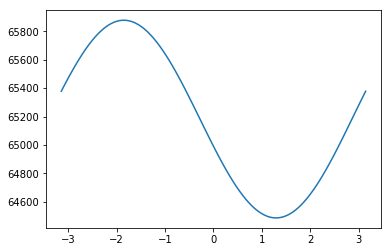

In [5]:
theta = np.linspace(-np.pi,np.pi,100)
val_F = []
P_modif = copy.deepcopy(P)
for thetai in theta:
    for j in range(1,len(P)):
        P_modif[j][2] = thetai
    val_F += [fonction_f(P_modif)]
X0 = theta
Y0 = np.array(val_F)
plt.plot(X0,Y0)
plt.show()

On remarque que la courbe de cette fonction $F$ n'est pas convexe. À forciori, $f$ ne peut pas être convexe non plus.

La recherche d'un minimum global n'est donc pas garantie et les algorithmes de recherche classiques vus dans le cours pourront converger vers un minimum local mais pas nécessairement global.

En revanche, on peut définir la fonction $f$ sur un compact. En effet, les variables $x$ et $y$ étant sensées être de telle sorte que le point $(x, y)$ appartienne à la carte du laboratoire d'INTEL, on peut les définir sur les intervalles fermés correspondant aux dimensions du laboratoire. Les angles étant définis sur des fermés, toutes les variables peuvent être définies sur des fermés dont le produit est un compact. La fonction f étant clairement réelle et continue sur ce compact là, alors le recherche de minimum global possède une solution d'après le théorème de $Weierstrass$.

#### Question 4 : 

In [6]:
#P_new est le vecteur (x1, y1, theta1, ..., xn, yn, thetan)
P_new = []
for p in P[1:]:
    P_new += p

P_new = np.array(P_new)

gamma = 1
def f(p):
    """
    Cette fonction est implementee pour travailler sur le vecteur P_new=(x1, y1, theta1, ..., xn, yn, thetan)
    Cela sera beaucoup plus simple pour le calcul automatique de gradient et de hessienne
    """  
    
    #Init de la premiere somme avec le terme d'indice 0 x0, y0, theta0 (qui ne fait plus partie du vecteur P_new)
    sum1 = (p[0] - deltaP[0][1][0])**2 + (p[1] - deltaP[0][1][1])**2 + (p[2] - deltaP[0][1][2])**2
    for i in range(len(p)//3-1):
        None
        s1 = (p[3*(i+1)] - np.cos(p[3*i + 2])*deltaP[i+1][i+2][0] + np.sin(p[3*i + 2])*deltaP[i+1][i+2][1] - p[3*i])**2
        s2 = (p[3*(i+1) + 1] - np.sin(p[3*i + 2])*deltaP[i+1][i+2][0] - np.cos(p[3*i + 2])*deltaP[i+1][i+2][1] - p[3*i + 1])**2
        s3 = (p[3*(i+1) + 2] - deltaP[i+1][i+2][2] - p[3*i + 2])**2
        sum1 += s1 + s2 + s3

    sum2 = 0
    for (i,j) in L:
        if i == 0:
            xi = 0
            yi = 0
            thetai = 0
            xj = p[3*(j-1)]
            yj = p[3*(j-1) + 1]
            thetaj = p[3*(j-1) + 2]
        elif j == 0:
            xj = 0
            yj = 0
            thetaj = 0
            xi = p[3*(i-1)]
            yi = p[3*(i-1) + 1]
            thetai = p[3*(i-1) + 2]
        else:
            xi = p[3*(i-1)]
            yi = p[3*(i-1) + 1]
            thetai = p[3*(i-1) + 2]
            xj = p[3*(j-1)]
            yj = p[3*(j-1) + 1]
            thetaj = p[3*(j-1) + 2]
        s1 = (xj - np.cos(thetai)*deltaP[i][j][0] + np.sin(thetai)*deltaP[i][j][1] - xi)**2
        s2 = (yj - np.sin(thetai)*deltaP[i][j][0] - np.cos(thetai)*deltaP[i][j][1] - yi)**2
        s3 = (thetaj - deltaP[i][j][2] - thetai)**2
        sum2 += s1 + s2 +s3
        
    return(np.array(sum1 + gamma*sum2))

print(f(P_new))

612744.0158944317


In [7]:
def gradient_f(p) : 
    """
    Calcule le gradient de f en p
    Entree = fonction f, vecteur p = (x1, y1, theta1, x2, y2, theta2, ..., xn, yn, thetan)
    Sortie = gradient de f en p
    """
    gradf = autograd.grad(f)
    gradient = gradf(p)
    return(np.array(gradient))

print(gradient_f(P_new))

[  0.00000000e+00   0.00000000e+00   2.16840434e-19 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


In [17]:
# Conditions de Wolfe
def wolfe_step(fun, grad_fun, xk, pk, c1 = 0.25, c2 = 0.75, M = 5):
    l_moins = 0
    l_plus = 0
    f_xk = fun(xk)
    grad_f_xk = grad_fun(xk)
    li = 1 #- 2*0.1*abs(f_x) / np.dot(grad_f_x,d)
    i = 0
    while(i < M):
        if (fun(xk+li*pk)>(f_xk+c1*li*np.dot(grad_f_xk,pk))):
            l_plus = li
            li = (l_moins+l_plus)/2.0
        else:
            if (np.dot(grad_fun(xk+li*pk),pk) < c2*np.dot(grad_f_xk,pk)):
                l_moins = li
                if (l_plus == 0):
                    li = 2*li
                else:
                    li = (l_moins+l_plus)/2.0
            else:
                #print("Nb itérations : ", i)
                return li
        i = i + 1
    #print("Trop d'itérations de Wolfe")
    return li

In [18]:
def optim_BFGS(fun, grad_fun, x0, max_iter = 20, epsilon_grad_fun = 1e-8):
    k = 0
    xk = x0
    grad_f_xk = grad_fun(xk)
    Hk = np.identity(len(x0))
    while ((k<max_iter) and (np.linalg.norm(grad_f_xk)>epsilon_grad_fun)):
        pk = -np.matmul(Hk,grad_f_xk)
        lk = wolfe_step(fun, grad_fun, xk, pk)
        xk1 = xk + lk*pk
        grad_f_xk1 = grad_fun(xk1)
        sk = xk1 - xk
        yk = grad_f_xk1 - grad_f_xk
        gammak = 1.0/np.dot(yk, sk)
        Ak = np.identity(len(x0)) - gammak*np.multiply(sk[:, np.newaxis], yk)
        Bk = np.identity(len(x0)) - gammak*np.multiply(yk[:, np.newaxis], sk)
        Hk = np.matmul(np.matmul(Ak, Hk), Bk) + gammak*np.multiply(sk[:, np.newaxis], sk)
        xk = xk1
        grad_f_xk = grad_f_xk1
        k = k + 1
    print("Nombre d'iterations : ", k)
    return xk

Nombre d'iterations :  20
[  6.05505620e-16  -9.55264524e-15  -6.42000000e-04 ...,  -7.59019004e+00
  -3.06356421e+01   8.35161863e+01]


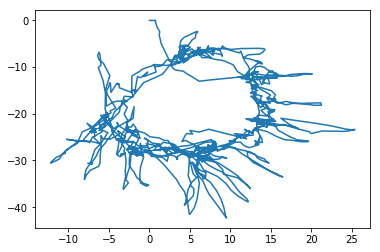

In [19]:
p_etoile = optim_BFGS(f,gradient_f,P_new)
print(p_etoile)
n = len(p_etoile)
X= np.array([p_etoile[3*i] for i in range(n//3)])
Y= np.array([p_etoile[3*i+1] for i in range(n//3)])
plt.plot(X,Y)
plt.show()

Nous avons choisi d'utiliser l'algorithme de BFGS pour traiter le problème d'optimisation précédent car il ne nécessite pas le calcul de la Hessienne de $f$ (qui est un calcul qui reste très long à traiter pour un ordinateur) et car le problème n'est pas un problème de recherche linéaire. Il est assez aisé d'implémenter cet algorithme.

On constate en revanche que le résultat obtenu est assez dépendant du nombre d'itérations effectuées lors de la réalisation de l'algorithme. En effet, si on note $n$ le nombre d'itérations lors de l'algorithme permettant de trouver un pas vérifiant les conditions de $Wolfe$, et $N$ le nombre d'itérations au sein de la boucle de l'algorithme BFGS, on obtient une complexité en $O(n*N)$ ce qui demande beaucoup de ressources à l'ordinateur.

Concernant le tracé optimisé, il semble correspondre aux formes du laboratoire d'INTEL, mais le parcours semble plus hératique que le tracé obtenu juste avec les relations d'odométrie.

## 3 - Etude avancée

#### Question 1 :

On introduit la matice $\Omega$ dans le produit scalaire. Il s'agit d'une produit scalaire pondéré. L'avantage est de pouvoir associer des poids différents aux différentes composantes du vecteur x lorsque l'on fait sa norme. Par exemple, si on désire accorder moins d'importance aux $\theta_i$ qu'aux $x_i$ et $y_i$, on mettra un coefficient moindre devant $\theta_i$.
Dans cette question on prend $\Omega$ diagonale, on aura donc $\|p\|^2_\Omega = \sum_{i=0}^N \Omega_{ii}p_i^2$

In [23]:
gamma = 0.1
omega = np.diag([1,1,0.1])

def f_omega(p):
    """
    Cette fonction tient compte de la nouvelle définition du produit scalire avec la matrice omega
    """  
    
    #Init de la premiere somme avec le terme d'indice 0 x0, y0, theta0 (qui ne fait plus partie du vecteur P_new)
    sum1 = (p[0] - deltaP[0][1][0])**2 + (p[1] - deltaP[0][1][1])**2 + (p[2] - deltaP[0][1][2])**2
    for i in range(len(p)//3-1):
        None
        s1 = (p[3*(i+1)] - np.cos(p[3*i + 2])*deltaP[i+1][i+2][0] + np.sin(p[3*i + 2])*deltaP[i+1][i+2][1] - p[3*i])**2
        s2 = (p[3*(i+1) + 1] - np.sin(p[3*i + 2])*deltaP[i+1][i+2][0] - np.cos(p[3*i + 2])*deltaP[i+1][i+2][1] - p[3*i + 1])**2
        s3 = (p[3*(i+1) + 2] - deltaP[i+1][i+2][2] - p[3*i + 2])**2
        sum1 += omega[0,0]*s1 + omega[1,1]*s2 + omega[2,2]*s3 #intervention des coefficients de la matrice omega 

    sum2 = 0
    for (i,j) in L:
        if i == 0:
            xi = 0
            yi = 0
            thetai = 0
            xj = p[3*(j-1)]
            yj = p[3*(j-1) + 1]
            thetaj = p[3*(j-1) + 2]
        elif j == 0:
            xj = 0
            yj = 0
            thetaj = 0
            xi = p[3*(i-1)]
            yi = p[3*(i-1) + 1]
            thetai = p[3*(i-1) + 2]
        else:
            xi = p[3*(i-1)]
            yi = p[3*(i-1) + 1]
            thetai = p[3*(i-1) + 2]
            xj = p[3*(j-1)]
            yj = p[3*(j-1) + 1]
            thetaj = p[3*(j-1) + 2]
        s1 = (xj - np.cos(thetai)*deltaP[i][j][0] + np.sin(thetai)*deltaP[i][j][1] - xi)**2
        s2 = (yj - np.sin(thetai)*deltaP[i][j][0] - np.cos(thetai)*deltaP[i][j][1] - yi)**2
        s3 = (thetaj - deltaP[i][j][2] - thetai)**2
        sum2 += omega[0,0]*s1 + omega[1,1]*s2 + omega[2,2]*s3
        
    return(np.array(sum1 + gamma*sum2))

In [24]:
def gradient_f_omega(p) : 
    gradf = autograd.grad(f_omega)
    gradient = gradf(p)
    return(np.array(gradient))

Nombre d'iterations :  20


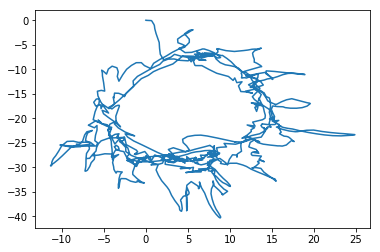

In [25]:
p_etoile = optim_BFGS(f_omega,gradient_f_omega,P_new)
n = len(p_etoile)
X= np.array([p_etoile[3*i] for i in range(n//3)])
Y= np.array([p_etoile[3*i+1] for i in range(n//3)])
plt.plot(X,Y)
plt.show()

Voici le résultat obtenu lors de l'utilisation de l'algorithme utilisant la matrice $\Omega$. Le tracé semble semble moins hératique que précédemment (on a ici affaibli le poids des $\theta$).

In [28]:
with open(r"MIT.txt", "r") as contenu:
    #Ouverture du fichier
    
    L = [] #L est la liste des relations de fermeture de boucle 
    c = 0 #c compte le nombre de points 

    for ligne in contenu :
        if "EDGE_ODO" in ligne:
            c += 1

with open(r"MIT.txt", "r") as contenu:

    #Creation de la matrice des Delta(ij)
    deltaP = [[0 for i in range(c+1)] for j in range(c+1)]

    for ligne in contenu :
        contenu_ligne = ligne.split()
        if "EDGE_ODO" in ligne:
            #Stockage des dx, dy, dtheta
            i = int(contenu_ligne[1])
            deltaP[i][i+1] = [float(contenu_ligne[3]), float(contenu_ligne[4]), float(contenu_ligne[5])]
        elif "EDGE_LOOP" in ligne :
            i = int(contenu_ligne[1])
            j = int(contenu_ligne[2])
            L.append((i,j))
            deltaP[i][j] = [float(contenu_ligne[3]), float(contenu_ligne[4]), float(contenu_ligne[5])]
            
P = [[0.,0.,0.]]           #Liste des [x, y, theta] pour chaque position
for i in range(c) :
    #Calculs des positions par iteration grace aux formules de recurrence
    delta = deltaP[i][i+1]
    P += [[(np.cos(P[-1][2])*delta[0] - np.sin(P[-1][2])*delta[1] + P[-1][0]),
    (np.sin(P[-1][2])*delta[0] + np.cos(P[-1][2])*delta[1] + P[-1][1]),
    (P[-1][2] + delta[2])]]
    
#P_new est le vecteur (x1, y1, theta1, ..., xn, yn, thetan)
P_new2 = []
for p in P[1:]:
    P_new2 += p

P_new2 = np.array(P_new2)

Nombre d'iterations :  20


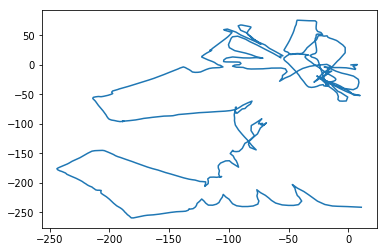

In [29]:
p_etoile = optim_BFGS(f_omega,gradient_f_omega,P_new2)
n = len(p_etoile)
X= np.array([p_etoile[3*i] for i in range(n//3)])
Y= np.array([p_etoile[3*i+1] for i in range(n//3)])
plt.plot(X,Y)
plt.show()

On peut essayer de reconnaître dans ce tracé les deux ailes du bâtiment de gauche. En revanche, on ne peut pas plus en dire sur le résultat...

In [ ]:
$$FIN$$